# Speeding up Python programs with Cython

Python scripts are usually *interpreted*.

- Good: When you change the script, you don’t need to compile it
- Bad: Interpretation adds runtime overhead.

To compensate, Python lets you write modules in C.

## Regular modules

Python modules are anything that can be imported. A module written in Python:

In [1]:
import gzip
gzip.__file__

'/usr/lib/python3.6/gzip.py'

In [2]:
!head /usr/lib/python3.6/gzip.py

"""Functions that read and write gzipped files.

The user of the file doesn't have to worry about the compression,
but random access is not allowed."""

# based on Andrew Kuchling's minigzip.py distributed with the zlib module

import struct, sys, time, os
import zlib
import builtins


## Extension modules

Modules written in C are called *extension modules*. They need to be compiled into a shared object (`.so` on Linux).

On import, the `.so` is found:

In [3]:
import audioop  # Standard library module that happens to be an extension module
print(audioop.__file__)

/usr/lib/python3.6/lib-dynload/audioop.cpython-36m-x86_64-linux-gnu.so


## Reasons for writing extension modules

1. Interfacing to an existing library written in C (or one that can be accessed from C). Example: pysam (interfaces with htslib)
2. Making Python scripts faster.

## Strategy

1. Write you script
2. Decide that it is too slow
3. Find the bottleneck by profiling. It’s often an inner loop or a single function.
4. Write an extension module only for the bottleneck.

Advantage: You write as little C as possible, stay in Python for most of the code.

Many known packages mix Python and C this way:
- NumPy
- Pandas
- SciPy
- BioPython
- TensorFlow

Also: Cutadapt

## Example: UMI clustering

To check randomness of UMIs, we want to do an all-vs-all sequence comparison using Hamming distance and display the distance matrix as a "cluster plot".

We want to see the plot here in the notebook:

In [4]:
%matplotlib inline

Import Seaborn, which will make the cluster plot.

The other imports are needed to massage the data.

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy.cluster import hierarchy

Read a couple of UMIs:

In [6]:
with open("umis.txt") as f:
    umis = [line.strip() for line in f]
len(umis)

# We are only going to plot 2000 of them, otherwise it gets too crowded
umis = umis[:2000]

In [7]:
umis[:10]

['TTCCTTCACTAATTAACATG',
 'GTCGGATGCAAGTGCCGGTA',
 'TTCGCATACGAATAAGTTCG',
 'CACGTGCGGGCCCATCGATC',
 'CTAACTCGTTAATAACTGTG',
 'GAAAGTCAGATGCTTATATA',
 'CGTGGGTGGTAATGAGCGTG',
 'TGAAGTTCCTTACTACTTTC',
 'TAAGCGACTAACCTCGCTAA',
 'CTAACTTCTGTAGTTCGGAA']

We will use the Hamming distance for simplicity

In [8]:
def hamming_distance_py(s, t):
    if len(s) != len(t):
        raise IndexError("Sequences must have the same length")
    dist = 0
    for c, d in zip(s, t):
        if c != d:
            dist += 1
    return dist

assert hamming_distance_py("ABCDEFGHIJKLMNOPQRSTUVWXYZ", "ABCDEFghiJKLMNOPQRStuvWXYZ") == 6

Now, the pairwise distance computation. The output is a “condensed distance matrix” in SciPy terminology. It only contains the upper triangle of the matrix.

In [9]:
def distances(sequences, distfunc):
    n = len(sequences)
    triangle = np.zeros(n * (n - 1) // 2, dtype=float)
    index = 0
    for i, s in enumerate(sequences):
        for j in range(i + 1, n):
            triangle[index] = distfunc(s, sequences[j])
            index += 1
    return triangle

In [10]:
distances(["ABB", "XYZ", "ABC", "BBD"], hamming_distance_py)

array([3., 1., 2., 3., 3., 2.])

Corresponds to:
$$
\left(
\begin{array}{cccc}
0 & \underline{3} & \underline{1} & \underline{2}\\
3 & 0 & \underline{3} & \underline{3}\\
1 & 3 & 0 & \underline{2}\\
2 & 3 & 2 & 0\\
\end{array}
\right)
$$


Finally, the plotting function (we are going to ignore the details)

In [11]:
def plot_clustermap(sequences, distfunc):   
    triangle = distances(sequences, distfunc)
    linkage = hierarchy.linkage(triangle, method='average')
    fig = sns.clustermap(
        pd.DataFrame(distance.squareform(triangle)),
        row_linkage=linkage,
        col_linkage=linkage,
        linewidths=None,
        linecolor='none',
        figsize=(200/25.4, 200/25.4),
        xticklabels=False,
        yticklabels=False
    )
    return fig

Let us see the result but also measure how long it takes.

9.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


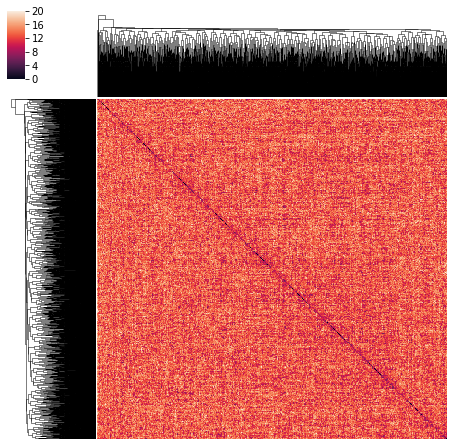

In [12]:
%%timeit -r1 -n1
plot_clustermap(umis, distfunc=hamming_distance_py)

## Where’s the bottleneck? – Profiling



We guess that distance computation is slowest:

In [13]:
%%timeit -n1 -r1
distances(umis, distfunc=hamming_distance_py)

6.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Yes, but how do we do this more systematically? By running a profiler.

Jupyter has the `%prun` magic for this (`-l 10`: Show the top 10 slowest functions)

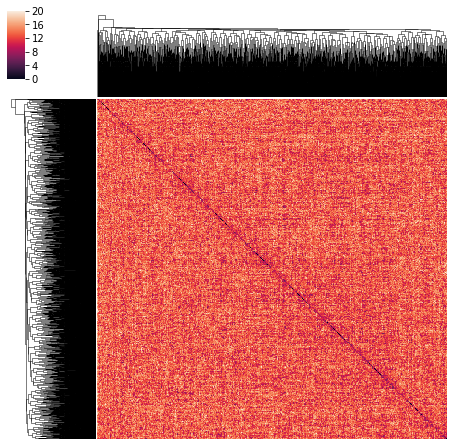

In [14]:
%prun -l 10 plot_clustermap(umis, distfunc=hamming_distance_py)

## Profiling output

---
```
6363493 function calls (6350940 primitive calls) in 9.574 seconds

   Ordered by: internal time
   List reduced from 1392 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1999000    5.695    0.000    6.003    0.000 <ipython-input-202-ddc01f42bfbe>:1(hamming_distance_py)
        2    1.434    0.717    1.434    0.717 {method 'draw_quad_mesh' of 'matplotlib.backends._backend_agg.RendererAgg' objects}
        1    1.008    1.008    7.012    7.012 <ipython-input-199-0f1b2e369524>:1(distances)
4005348/4005146    0.310    0.000    0.310    0.000 {built-in method builtins.len}
     1549    0.191    0.000    0.191    0.000 {method 'reduce' of 'numpy.ufunc' objects}
12593/12592    0.083    0.000    0.083    0.000 {built-in method numpy.array}
        5    0.070    0.014    0.077    0.015 {method 'draw_path_collection' of 'matplotlib.backends._backend_agg.RendererAgg' objects}
        6    0.067    0.011    0.067    0.011 {method 'take' of 'numpy.ndarray' objects}
        7    0.061    0.009    0.061    0.009 {built-in method matplotlib._path.update_path_extents}
        1    0.060    0.060    0.060    0.060 {scipy.cluster._hierarchy.nn_chain}
```
---

- The bottleneck is in the `hamming_distance_py` function: It was called 1999000 times and was responsible for 5.7 s of total runtime.

## Cython

- Writing extension modules in C directly is verbose and error-prone:
  - Manual memory management
  - Manual reference counting
  - Manually packing arguments into tuples when calling functions
- Cython allows to write compiled extension modules in a Python-like language
- We will use it to speed up the `hamming_distance()` function

First, we load a standard Jupyter extension that allows us to put Cython code into cells:

In [15]:
%load_ext Cython

- Normally, Cython code is put into `.pyx` files (historic leftover from its old name “Pyrex”)
- But you need a packaged Python project with a `setup.py` file that will control compilation.
- For simplicity, we use Jupyter’s extension, which automatically compiles for us

Speed of original Hamming distance function:

In [16]:
%%timeit
hamming_distance_py("abcDEFGHIJKLMNOPQRSTUVWXYZ", "ABCDEFghiJKLMNOPQRStuvWXYZ")

2.89 µs ± 128 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## A Cython version of hamming_distance

Cython is intended to be a superset of Python.

That is, you can put in your Python code unchanged, run it through Cython and get some speedup due to compilation:

In [17]:
%%cython

def hamming_distance_cy1(s, t):
    if len(s) != len(t):
        raise IndexError("Sequences must have the same length")
    dist = 0
    for c, d in zip(s, t):
        if c != d:
            dist += 1
    return dist

What happened?

- The Cython compiler complied the above Python code to C
- The C code was compiled into machine code

In [18]:
%%timeit
hamming_distance_cy1("abcDEFGHIJKLMNOPQRSTUVWXYZ", "ABCDEFghiJKLMNOPQRStuvWXYZ")

1.9 µs ± 61.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Nice: This is faster than the Python version.

Cython works by compiling our code to C. Let’s look at it with `--annotate`:

In [19]:
%%cython --annotate

def hamming_distance_cy1(s, t):
    if len(s) != len(t):
        raise IndexError("Sequences must have the same length")
    dist = 0
    for c, d in zip(s, t):
        if c != d:
            dist += 1
    return dist

Everything is somewhat yellow, which means we still call many – often slow – Python functions.

For computing `dist += 1`, Cython generates code that *calls a function*. Written as above, `dist` could be anything, and Cython needs to generate code that deals with the dynamism.

To get faster, we need to declare variable types.

In [20]:
%%cython

def hamming_distance_cy2(str s, str t):
    if len(s) != len(t):
        raise IndexError("Sequences must have the same length")
    cdef unsigned dist = 0
    for c, d in zip(s, t):
        if c != d:
            dist += 1
    return dist

In [21]:
%%cython --annotate

def hamming_distance_cy2(str s, str t):
    if len(s) != len(t):
        raise IndexError("Sequences must have the same length")
    cdef unsigned dist = 0
    for c, d in zip(s, t):
        if c != d:
            dist += 1
    return dist

In [22]:
%%timeit
hamming_distance_cy2("abcDEFGHIJKLMNOPQRSTUVWXYZ", "ABCDEFghiJKLMNOPQRStuvWXYZ")

1.91 µs ± 245 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


This didn’t help that much. Let’s rewrite a bit more so it looks more like what one would write in C.

In [23]:
%%cython --annotate

def hamming_distance_cy3(str s, str t):
    cdef:
        Py_ssize_t m = len(s)
        Py_ssize_t n = len(t)
        Py_ssize_t e = 0
        Py_ssize_t i
    if m != n:
        raise IndexError("sequences must have the same length")
    for i in range(m):
        if s[i] != t[i]:
            e += 1
    return e

In [24]:
%%timeit
hamming_distance_cy3("abcDEFGHIJKLMNOPQRSTUVWXYZ", "ABCDEFghiJKLMNOPQRStuvWXYZ")

228 ns ± 18.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Now we’re talking!

Let’s go a bit further by removing some safety checks.

- `wraparound` allows using negative indices
- `boundscheck` ensures that out-of-bounds indices raise an exception

In [25]:
%%cython
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def hamming_distance_cy4(str s, str t):
    cdef:
        Py_ssize_t m = len(s)
        Py_ssize_t n = len(t)
        Py_ssize_t e = 0
        Py_ssize_t i
    if m != n:
        raise IndexError("sequences must have the same length")
    for i in range(m):
        if s[i] != t[i]:
            e += 1
    return e

In [26]:
%%timeit
hamming_distance_cy4("abcDEFGHIJKLMNOPQRSTUVWXYZ", "ABCDEFghiJKLMNOPQRStuvWXYZ")

221 ns ± 6.94 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


3.88 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


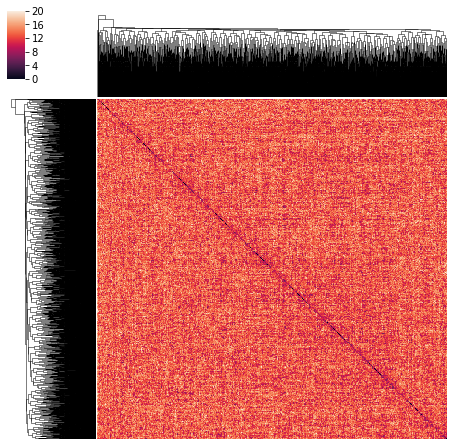

In [27]:
%%timeit -n1 -r1
figure = plot_clustermap(umis, distfunc=hamming_distance_cy4)

# Result

Hamming distance computation got **14 times** faster (2.73 µs → 192 ns)

Overall plotting got **2.5 times** faster (8.8 s → 3.4 s)

## Cython outside of Jupyter

- Turn your Python tool into a proper package (with a `setup.py`)
- Write `.pyx` files with your Cython modules
- List extension modules in `setup.py`

A small Cython project example is at https://github.com/marcelm/alignlib .

# Appendix

## Python, CPython etc.

The Python language is different from its implementation.

Some Python language implementations:

- CPython – the official/canonical one from python.org
- PyPy
- Nuitka
- Micropython
- Cython

## Other options for making Python faster

- [Numba](https://numba.pydata.org/)
- [PyPy](https://pypy.org/)
- [Nuitka](https://nuitka.net/)

## Annotation on the command line


    $ cython -a mymodule.pyx

Creates `mymodule.html`

## Profiling on the command line


Run script in profiler:

    python3 -m cProfile -o mymodule.prof mymodule.py

Now look at the created profiling data in `mymodule.prof`:

    python3 -m pstats mymodule.prof

Example session:

```
Welcome to the profile statistics browser.
mymodule.prof% sort tottime
mymodule.prof% stats 10
Mon Aug 19 13:28:04 2019    umi.prof

         7693036 function calls (7654365 primitive calls) in 17.673 seconds

   Ordered by: internal time
   List reduced from 8432 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1999000    6.022    0.000    6.340    0.000 umi.py:31(hamming_distance_py)
        6    4.541    0.757    4.542    0.757 {method 'draw_quad_mesh' of 'matplotlib.backends._backend_agg.RendererAgg' objects}
        2    1.991    0.995    1.991    0.995 {built-in method matplotlib._png.write_png}
        1    1.873    1.873    8.213    8.213 umi.py:41(distances)
4112786/4111642    0.331    0.000    0.331    0.000 {built-in method builtins.len}
     2881    0.181    0.000    0.181    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     1240    0.126    0.000    0.126    0.000 {built-in method marshal.loads}
15516/15514    0.120    0.000    0.121    0.000 {built-in method numpy.array}
        9    0.109    0.012    0.120    0.013 {method 'draw_path_collection' of 'matplotlib.backends._backend_agg.RendererAgg' objects}
        1    0.075    0.075    0.075    0.075 {scipy.cluster._hierarchy.nn_chain}

mymodule.prof%
```